# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [1]:
import torch
from torchvision import datasets, transforms

In [4]:
x = datasets.MNIST('data', download = True)
x[0]

Failed to download (trying next):
HTTP Error 403: Forbidden



12.9%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Failed to download (trying next):
HTTP Error 403: Forbidden

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




47.7%

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(<PIL.Image.Image image mode=L size=28x28>, 5)

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [6]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [7]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

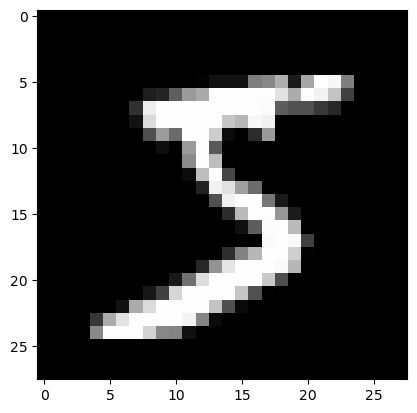

In [9]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

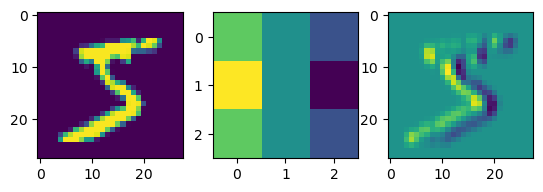

In [10]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [13]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_23514/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [14]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

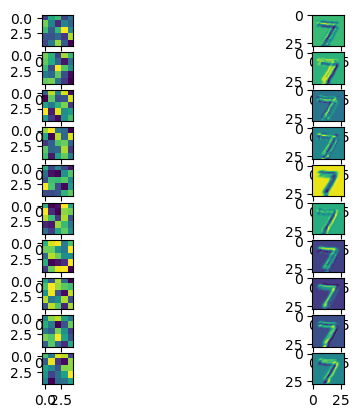

In [15]:
visualize()

# Predict Using Network

In [16]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [22]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_23514/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([7, 7, 7, 7, 7])

# First Test and Train

In [23]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [24]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_23514/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 8%



In [25]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [26]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_23514/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.326920
Train loss: 1.759441
Train loss: 1.171852
Train loss: 0.796867
Train loss: 0.707732
Train loss: 0.726064
Train loss: 0.453979
Train loss: 0.622776
Train loss: 0.546286
Train loss: 0.491214


In [27]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_23514/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.325555
Train loss: 1.797474
Train loss: 1.156546
Train loss: 0.898747
Train loss: 0.573412
Train loss: 0.775896
Train loss: 0.421299
Train loss: 0.612620
Train loss: 0.694382
Train loss: 0.624160
Test accuracy: 94%

Train loss: 0.316930
Train loss: 0.326965
Train loss: 0.373143
Train loss: 0.546263
Train loss: 0.269763
Train loss: 0.419867
Train loss: 0.270094
Train loss: 0.376994
Train loss: 0.380681
Train loss: 0.249820
Test accuracy: 96%

Train loss: 0.304776
Train loss: 0.296558
Train loss: 0.197407
Train loss: 0.314551
Train loss: 0.405430
Train loss: 0.344067
Train loss: 0.288454
Train loss: 0.358280
Train loss: 0.416303
Train loss: 0.209035
Test accuracy: 97%

Train loss: 0.195778
Train loss: 0.242028
Train loss: 0.179339
Train loss: 0.260259
Train loss: 0.247977
Train loss: 0.399768
Train loss: 0.261955
Train loss: 0.361955
Train loss: 0.530806
Train loss: 0.264557
Test accuracy: 97%

Train loss: 0.169781
Train loss: 0.171269
Train loss: 0.068577
Train loss: 0.262

# Inspect Network

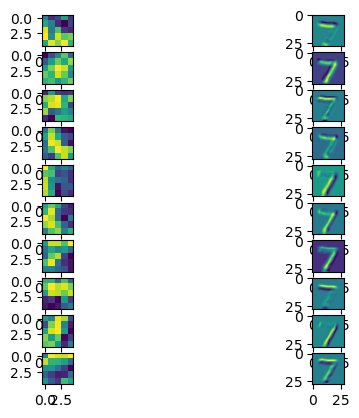

In [28]:
visualize()

In [29]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [30]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_23514/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [36]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [37]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_23514/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.329834
Train loss: 1.975624
Train loss: 1.163447
Train loss: 0.640824
Train loss: 0.644640
Train loss: 0.737336
Train loss: 0.520063
Train loss: 0.705951
Train loss: 0.444538
Train loss: 0.417290
Test accuracy: 94%

Train loss: 0.376066
Train loss: 0.425530
Train loss: 0.373250
Train loss: 0.520777
Train loss: 0.330120
Train loss: 0.298501
Train loss: 0.325488
Train loss: 0.405349
Train loss: 0.329186
Train loss: 0.455539
Test accuracy: 97%

Train loss: 0.157587
Train loss: 0.179145
Train loss: 0.230277
Train loss: 0.519226
Train loss: 0.242708
Train loss: 0.293025
Train loss: 0.289557
Train loss: 0.417621
Train loss: 0.270710
Train loss: 0.327023
Test accuracy: 97%

Train loss: 0.171007
Train loss: 0.285910
Train loss: 0.271699
Train loss: 0.397308
Train loss: 0.124244
Train loss: 0.170982
Train loss: 0.199912
Train loss: 0.202182
Train loss: 0.219711
Train loss: 0.378021
Test accuracy: 97%

Train loss: 0.231986
Train loss: 0.115229
Train loss: 0.265175
Train loss: 0.468

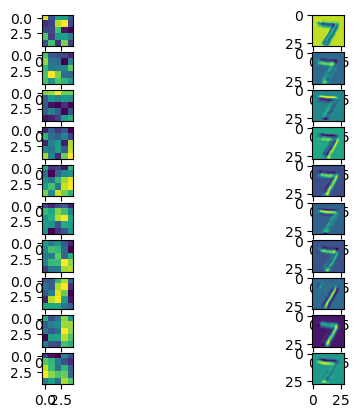

In [40]:
visualize()

In [38]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [39]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_23514/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.311482
Train loss: 2.042690
Train loss: 1.047511
Train loss: 0.821232
Train loss: 0.677026
Test accuracy: 91%

Train loss: 0.702306
Train loss: 0.474830
Train loss: 0.458435
Train loss: 0.588822
Train loss: 0.342532
Test accuracy: 94%

Train loss: 0.481464
Train loss: 0.557535
Train loss: 0.394250
Train loss: 0.457040
Train loss: 0.269399
Test accuracy: 96%

Train loss: 0.321156
Train loss: 0.295232
Train loss: 0.338959
Train loss: 0.345249
Train loss: 0.283747
Test accuracy: 96%

Train loss: 0.412659
Train loss: 0.181157
Train loss: 0.284324
Train loss: 0.403114
Train loss: 0.177741
Test accuracy: 97%



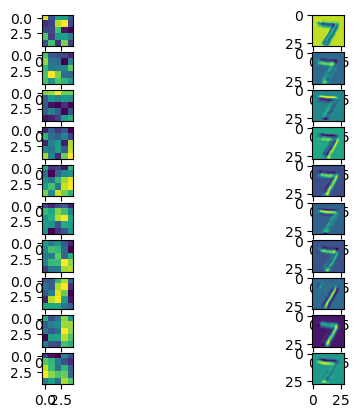

In [41]:
visualize()

In [42]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [43]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_23514/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.310781
Test accuracy: 52%

Train loss: 2.092686
Test accuracy: 80%

Train loss: 1.267150
Test accuracy: 86%

Train loss: 0.937452
Test accuracy: 89%

Train loss: 0.689701
Test accuracy: 91%



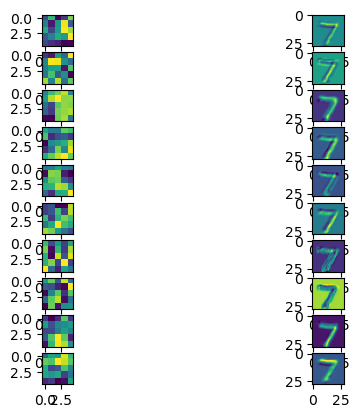

In [44]:
visualize()

In [45]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [46]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_23514/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.376106
Test accuracy: 44%

Train loss: 2.212488
Test accuracy: 68%

Train loss: 1.863985
Test accuracy: 75%

Train loss: 1.386850
Test accuracy: 81%

Train loss: 1.191851
Test accuracy: 85%



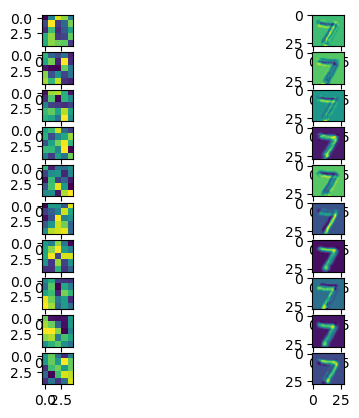

In [47]:
visualize()

In [48]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [49]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_23514/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.290905
Test accuracy: 12%

Train loss: 2.301809
Test accuracy: 13%

Train loss: 2.280948
Test accuracy: 20%

Train loss: 2.273195
Test accuracy: 23%

Train loss: 2.246803
Test accuracy: 24%



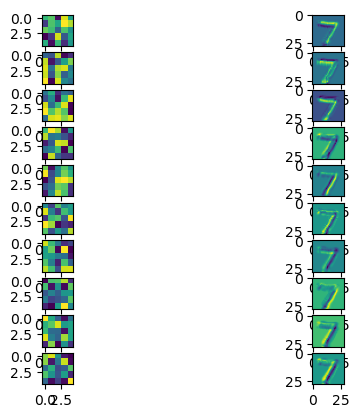

In [50]:
visualize()

In [ ]:
1a. What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
Overall, the accuracy increases with more images present. These are the averages:
60,000 = ~96.6%
30,000 = ~94.8%
6,000 = ~79.6%
3,000 = ~70.6%
600 = ~18.4%
1b. How do the weights looks different when trained with 60,000 vs 600?
The weights when trained with 600 images seem more random and disorganized compared to using 60,000 images that seem to have some clustering in their visualization.